In [1]:
import os as os
import sys as sys
import re as re
import pandas as pd
import numpy as np
import json as json
import pickle
import urllib as urllib
import zlib as zlib
import base64 as base64
from requests import Request, Session
import requests
from numpy import trapz
import itertools
import zlib as zlib
import base64 as base64
import pickle
import pathlib
from tqdm import tqdm
from datetime import datetime
import time
import copy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100
pd.options.display.min_rows = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 100

DATA_PATH = pathlib.Path('/data1/home/adpatter/gene-to-phenotype-predictions/adpatter/data/')
EFFECT_SIZE_PATH = DATA_PATH.joinpath('capstone_body_weight_Statistical_effect_size_analysis_genotype_early_adult_scaled_13022023_gene_symbol_harmonized.pkl')
PROTEIN_SEQ_PATH = DATA_PATH.joinpath('gene_symbol_protein_sequences.pkl')
EXON_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_exon.pkl')
UNSPLICED_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_unspliced.pkl')

In [2]:
df = pd.read_pickle(EFFECT_SIZE_PATH)

df = df.loc[df['zygosity'] == 'homozygote']

df = df.groupby(['gene_symbol_harmonized'], group_keys=False).apply(lambda x: x.loc[x['est_m_ea'] == x['est_m_ea'].max()])

df_effect_size = df.copy()

In [3]:
df = pd.read_pickle(PROTEIN_SEQ_PATH)

df_protein_seq = df.copy()

In [4]:
df = df_protein_seq.copy()

df = df.loc[df['motifs'].notna()]

df = df_effect_size.merge(df, how='inner', on='gene_symbol_harmonized')

df['class'] = (df['est_m_ea'] >= df['est_m_ea'].mean()).apply(lambda x: 'gte mean' if x else 'lt mean')

df = df[['class', 'motifs']]

df_protein_seq_0 = df.copy()

df

,class,motifs
0,lt mean,DTD
1,gte mean,HGG
2,gte mean,AKL
3,gte mean,CRL
4,gte mean,AKL
5,lt mean,SKL
6,gte mean,SQL
7,lt mean,MRCGLSEE
8,gte mean,STCSGMSG
9,gte mean,RGD


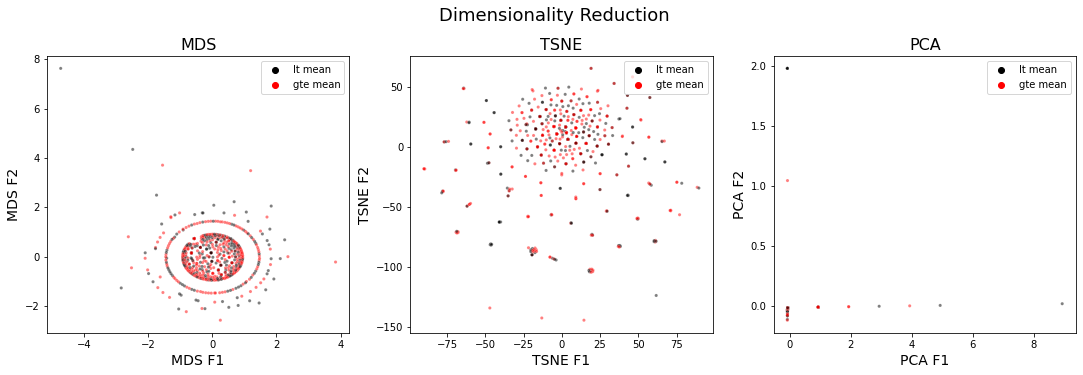

In [5]:
df = df_protein_seq_0.copy()

corpus = df['motifs'].tolist()

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))

X = vectorizer.fit_transform(corpus).toarray()

y = df['class']

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

fig.suptitle('Dimensionality Reduction', fontsize=18)

fig.patch.set_facecolor('white')

fig.set_size_inches(25, 5)

palette={
        'gte mean': 'red', 
        'lt mean': 'black',
        }

ax1.set_title(label='MDS', fontdict={'fontsize':16})
ax2.set_title(label='TSNE', fontdict={'fontsize':16})
ax3.set_title(label='PCA', fontdict={'fontsize':16})

fig.set_size_inches(15, 5)
fig.tight_layout(pad=1, w_pad=3)

mds = MDS(n_components=2)

X_mds = mds.fit_transform(X)

df = pd.DataFrame(X_mds, columns=['MDS F1', 'MDS F2'])

mds_axes = sns.scatterplot(
    data=df, 
    x="MDS F1", 
    y="MDS F2", 
    hue=y, 
    alpha=0.5,
    palette=palette,
    ax=ax1,
    s=10
    )

tsne = TSNE(
    n_components=2, 
    learning_rate='auto',
    init='random', 
    perplexity=3)
    
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, columns=['TSNE F1', 'TSNE F2'])

tsne_axes = sns.scatterplot(
    data=df, 
    x="TSNE F1", 
    y="TSNE F2", 
    hue=y, 
    alpha=0.5,
    palette=palette,
    ax=ax2,
    s=10
    )
    
pca = PCA(n_components=2)
    
X_pca = pca.fit_transform(X)

df = pd.DataFrame(X_pca, columns=['PCA F1', 'PCA F2'])

pca_axes = sns.scatterplot(
    data=df, 
    x="PCA F1", 
    y="PCA F2", 
    hue=y,
    alpha=0.5,
    palette=palette,
    ax=ax3,
    s=10
    )

ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)

for axes_subplot in fig.axes:
    axes_subplot.legend(loc='upper right')